In [70]:
import sys
sys.path.append('lib/src/')
import torch
from torch import nn
import os
from matplotlib import pyplot as plt
import lightning as L
from sklearn.decomposition import PCA

from lib.src.pythae.models import VAE
from lib.scripts.utils import Encoder_Chairs,Decoder_Chairs, My_Dataset, My_MaskedDataset, make_batched_masks
from lib.src.pythae.models.vae import VAEConfig
from lib.src.pythae.trainers import BaseTrainerConfig
from lib.src.pythae.pipelines.training import TrainingPipeline
from lib.src.pythae.samplers.normal_sampling import NormalSampler
from lib.src.pythae.samplers.manifold_sampler import RHVAESampler

sys.path.append('diffusion/stable_diffusion/')
sys.path.append('diffusion/stable_diffusion/model/')
from diffusion.stable_diffusion.latent_diffusion import LatentDiffusion, DiffusionWrapper, MyLatentDiffusion
from diffusion.stable_diffusion.model.autoencoder import Autoencoder
from diffusion.stable_diffusion.model.clip_embedder import CLIPTextEmbedder
from diffusion.stable_diffusion.model.unet import UNetModel, _test_time_embeddings
from diffusion.stable_diffusion.sampler.ddim import DDIMSampler
from diffusion.stable_diffusion.sampler.ddpm import DDPMSampler

%reload_ext autoreload
%autoreload 2

In [71]:
!nvidia-smi

Thu May 30 13:51:36 2024       
+-----------------------------------------------------------------------------------------+
| NVIDIA-SMI 550.78                 Driver Version: 550.78         CUDA Version: 12.4     |
|-----------------------------------------+------------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id          Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |           Memory-Usage | GPU-Util  Compute M. |
|                                         |                        |               MIG M. |
|=========================================+========================+======================|
|   0  NVIDIA RTX A2000 12GB          Off |   00000000:01:00.0  On |                  Off |
| 30%   39C    P8             11W /   70W |     489MiB /  12282MiB |      0%      Default |
|                                         |                        |                  N/A |
+-----------------------------------------+-----

In [5]:
#device = 'cuda' if torch.cuda.is_available() else 'cpu'
device = 'cpu'
train_data = torch.load(os.path.join('lib/my_data/sprites/Sprites_train.pt'))[:-1000, -1, :, :, :].to(device) #only keeping the last frame of each sequence
eval_data = torch.load(os.path.join('lib/my_data/sprites/Sprites_train.pt'), map_location="cpu")[-1000:, -1, :, :, :].to(device)
test_data = torch.load(os.path.join('lib/my_data/sprites/Sprites_test.pt'), map_location="cpu")[:, -1, :, :, :].to(device)
print(train_data.shape)
train_data = train_data.permute(0, 3, 1, 2)
eval_data = eval_data.permute(0, 3, 1, 2)
test_data = test_data.permute(0, 3, 1, 2)
print(train_data.shape)

train_seq_mask = torch.ones(train_data.shape[:2], requires_grad=False).type(torch.bool).to(device)
eval_seq_mask = torch.ones(eval_data.shape[:2], requires_grad=False).type(torch.bool).to(device)
test_seq_mask = torch.ones(test_data.shape[:2], requires_grad=False).type(torch.bool).to(device)
train_pix_mask = torch.ones_like(train_data, requires_grad=False).type(torch.bool).to(device)
eval_pix_mask = torch.ones_like(eval_data, requires_grad=False).type(torch.bool).to(device)
test_pix_mask = torch.ones_like(test_data, requires_grad=False).type(torch.bool).to(device)

train_dataset = My_MaskedDataset(train_data, train_seq_mask, train_pix_mask)
eval_dataset = My_MaskedDataset(eval_data, eval_seq_mask, eval_pix_mask)
test_dataset = My_MaskedDataset(test_data, test_seq_mask, test_pix_mask)

torch.Size([8000, 64, 64, 3])
torch.Size([8000, 3, 64, 64])


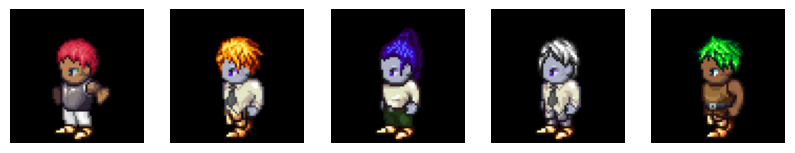

In [6]:
#check
plt.figure(figsize=(10, 10))
for i in range(5):
    plt.subplot(1, 5, i+1)
    plt.imshow(train_dataset[i][0].data.cpu().permute(1, 2, 0))
    plt.axis('off')
plt.show()

In [4]:
input_dim = (3, 64, 64)
f = 8 #subsampling factor
latent_dim = 3* (64 // f) * (64 // f)
print('Latent dim:', latent_dim)

training_config = BaseTrainerConfig(output_dir='my_model',
num_epochs=100,
learning_rate=1e-3,
per_device_train_batch_size=200,
per_device_eval_batch_size=200,
train_dataloader_num_workers=2,
eval_dataloader_num_workers=2,
steps_saving=50,
optimizer_cls="AdamW",
optimizer_params={"weight_decay": 0.05, "betas": (0.91, 0.995)},
scheduler_cls="ReduceLROnPlateau",
scheduler_params={"patience": 5, "factor": 0.5})


Latent dim: 192


In [38]:
device = 'cuda'
vae = VAE.load_from_folder('pre-trained_vae/VAE_training_2024-05-22_14-43-10/final_model').to(device)
vae.eval()
# out = vae(train_dataset[:-1].to(device))
# print(out.reconstruction_loss)
# print(out.reg_loss)

VAE(
  (decoder): Decoder_Chairs(
    (fc): Linear(in_features=192, out_features=2048, bias=True)
    (layers): Sequential(
      (0): ConvTranspose2d(128, 128, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
      (1): ResBlock(
        (conv_block): Sequential(
          (0): ReLU()
          (1): Conv2d(128, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
          (2): ReLU()
          (3): Conv2d(32, 128, kernel_size=(1, 1), stride=(1, 1))
        )
      )
      (2): ResBlock(
        (conv_block): Sequential(
          (0): ReLU()
          (1): Conv2d(128, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
          (2): ReLU()
          (3): Conv2d(32, 128, kernel_size=(1, 1), stride=(1, 1))
        )
      )
      (3): ResBlock(
        (conv_block): Sequential(
          (0): ReLU()
          (1): Conv2d(128, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
          (2): ReLU()
          (3): Conv2d(32, 128, kernel_size=(1, 1), stride=(1, 1))
        )
 

In [35]:
train_loader = torch.utils.data.DataLoader(train_data, batch_size=100, num_workers = 19)
val_loader = torch.utils.data.DataLoader(eval_data, batch_size=100, num_workers = 19)
test_loader = torch.utils.data.DataLoader(test_data, batch_size=100, num_workers = 19)


# mu = []
# log_var = []
# with torch.no_grad():
#     for _ , x in enumerate(train_loader):

#         data = x.data

#         out = vae.encoder(data.to(device))

#         mu_data, log_var_data = out.embedding, out.log_covariance

#         mu.append(mu_data)
#         log_var.append(log_var_data)

# mu = torch.cat(mu)
# log_var = torch.cat(log_var)

x = next(iter(train_loader))
x.shape

torch.Size([100, 3, 64, 64])

In [9]:

def load_config_unet(config):
    return UNetModel(
        in_channels=config['in_channels'],
        out_channels=config['out_channels'],
        channels=config['channels'],
        n_res_blocks=config['n_res_blocks'],
        attention_levels=config['attention_levels'],
        channel_multipliers=config['channel_multipliers'],
        n_heads=config['n_heads'],
    )

In [36]:
######## UNET #######
# in_channels = 3
# out_channels = 3
# channels = 64
# n_res_blocks = 2
# attention_levels = [3]
# channel_multipliers = (1, 2, 2, 4)
# n_heads = 2

in_channels = 3
out_channels = 3
channels = 32
n_res_blocks = 2
attention_levels = [2]
channel_multipliers = (1, 2, 4)
n_heads = 16

unet_config = {
    'in_channels': in_channels,
    'out_channels': out_channels,
    'channels': channels,
    'n_res_blocks': n_res_blocks,
    'attention_levels': attention_levels,
    'channel_multipliers': channel_multipliers,
    'n_heads': n_heads,
}

unet = load_config_unet(unet_config)

z = torch.randn(1, 3, 8, 8)
empty_prompt_embed = None
print(unet(z, torch.tensor([10]), empty_prompt_embed).shape)
sum(p.numel() for p in unet.parameters() if p.requires_grad)

torch.Size([1, 3, 8, 8])


5721539

In [37]:
latent_scaling_factor = 1
n_steps = 1000
linear_start =  0.00085
linear_end = 1


latent_diffusion = MyLatentDiffusion(unet, None, latent_scaling_factor, n_steps, linear_start, linear_end)
sum(p.numel() for p in latent_diffusion.parameters() if p.requires_grad)

5721539

In [12]:
class LitLDM(L.LightningModule):
    def __init__(self, ldm, lr = 1e-3):
        super().__init__()
        self.ldm = ldm
        self.lr = lr

    def training_step(self, batch, batch_idx):
        # training_step defines the train loop.
        x = batch
        batch_size = x.shape[0]
        z = vae.encoder(x).embedding.reshape(-1, 3, 8, 8)
        noise = torch.randn_like(z)

        t = torch.randint(0, self.ldm.n_steps, (z.shape[0],)).to(z.device)

        noisy_z = self.ldm.add_noise(z, noise, t).float()

        noise_pred = self.ldm(noisy_z, t).reshape(batch_size, 3*8*8)
        noise = noise.reshape(batch_size, 3*8*8)

        #z_pred = (noisy_z - (1- self.ldm.alpha_bar[t].reshape(batch_size, 1, 1, 1)) ** 0.5 * noise_pred) / (self.ldm.alpha_bar[t].reshape(batch_size, 1, 1, 1) ** 0.5)

        loss = ((noise_pred - noise)**2).sum(axis=1).mean()

        self.log("train_loss", loss, prog_bar=True)


        return loss
    
    def validation_step(self, batch, batch_idx):
        x = batch
        batch_size = x.shape[0]
        z = vae.encoder(x).embedding.reshape(-1, 3, 8, 8)
        noise = torch.randn_like(z)

        t = torch.randint(0, self.ldm.n_steps, (batch_size,)).to(z.device)
        noisy_z = self.ldm.add_noise(z, noise, t).float()

        noise_pred = self.ldm(noisy_z, t).reshape(batch_size, 3*8*8)
        noise = noise.reshape(batch_size, 3*8*8)

        val_loss = ((noise_pred - noise)**2).sum(axis=1).mean()

        self.log("val_loss", val_loss, prog_bar = True)

    def configure_optimizers(self):
        optimizer = torch.optim.Adam(self.parameters(), lr=self.lr)
        scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, patience=2, factor=0.8)

        return {'optimizer':optimizer, 'lr_scheduler':scheduler, 'monitor':'train_loss'}

In [33]:
# n_steps = 1000
# linear_start =  0.00085
# linear_end = 0.05
# latent_scaling_factor = 1

# vae = vae.to('cuda')
# latent_diffusion = MyLatentDiffusion(unet, None, latent_scaling_factor, n_steps, linear_start, linear_end)
# model = LitLDM(latent_diffusion, lr=8e-4).to('cuda')


# trainer = L.Trainer(max_epochs=100,
#                      default_root_dir='ldm', accelerator = 'gpu', 
#                      check_val_every_n_epoch=5)


train_loader = torch.utils.data.DataLoader(train_data, batch_size=100, num_workers = 19)
val_loader = torch.utils.data.DataLoader(eval_data, batch_size=100, num_workers = 19)


# trainer.fit(model, train_loader, val_loader)

model = LitLDM.load_from_checkpoint('ldm/lightning_logs/version_15/checkpoints/epoch=99-step=8000.ckpt', ldm = latent_diffusion).to('cuda')

In [42]:
trainer = L.Trainer()
trainer.validate(model, val_loader)

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Validation: |          | 0/? [00:00<?, ?it/s]

────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
     Validate metric           DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
        val_loss            13.151440620422363
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────


[{'val_loss': 13.151440620422363}]

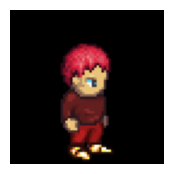

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


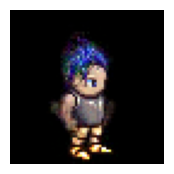

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


tensor(0.0625, grad_fn=<MseLossBackward0>)
tensor(22.1360, grad_fn=<MseLossBackward0>)
Coming from =  tensor(198.7814, grad_fn=<MseLossBackward0>)
Distance parcourue : tensor(189.2942, grad_fn=<MseLossBackward0>)


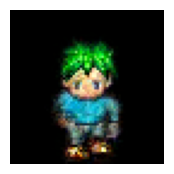

In [44]:
#Test en tant que denoiser

x= next(iter(val_loader))[2]
vae = vae.to('cpu')
model = model.to('cpu')

plt.figure(figsize=(2, 2))
plt.imshow(x.permute(1, 2, 0))
plt.axis('off')
plt.show()
#z = model.ldm.autoencoder_encode(x)
z = vae.encoder(x).embedding



t = torch.tensor([599])


noise = torch.randn_like(z)
noisy_z = model.ldm.add_noise(z, noise, t).float().reshape(-1, 3, 8, 8)

noisy_x = vae.decoder(noisy_z.reshape(-1, 192)).reconstruction

plt.figure(figsize=(2, 2))
plt.imshow(noisy_x[0].detach().permute(1, 2, 0))
plt.axis('off')
plt.show()

noise_pred= model.ldm(noisy_z, t)

print(nn.MSELoss(reduction = 'sum')(noise_pred.reshape(1, 192), noise))

#sampler = DDIMSampler(model.ldm, n_steps = 8)
# sampler = DDPMSampler(model.ldm)
# z_pred, _, _ = sampler.sample(shape=(1, 3, 8, 8), x_last = noisy_z, cond=None)


z_pred = (noisy_z - (1- model.ldm.alpha_bar[t]) ** 0.5 * noise_pred) / (model.ldm.alpha_bar[t] ** 0.5)
z_pred = z_pred.reshape(-1, 192).float()

#z_pred = z 

print(nn.MSELoss(reduction = 'sum')(z_pred, z.reshape(-1, 192)))
print('Coming from = ', nn.MSELoss(reduction = 'sum')(z, noisy_z.reshape(-1, 192)))
print('Distance parcourue :', nn.MSELoss(reduction = 'sum')(z_pred, noisy_z.reshape(-1, 192)))

#x_pred = model.ldm.autoencoder_decode(z_pred)
x_pred = vae.decoder(z_pred).reconstruction

plt.figure(figsize=(2, 2))
plt.imshow(x_pred[0].detach().permute(1, 2, 0))
plt.axis('off')
plt.show()






Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


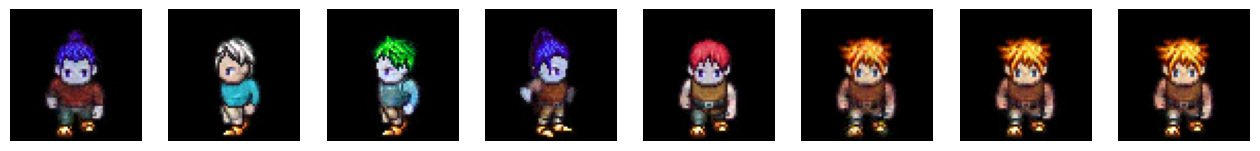

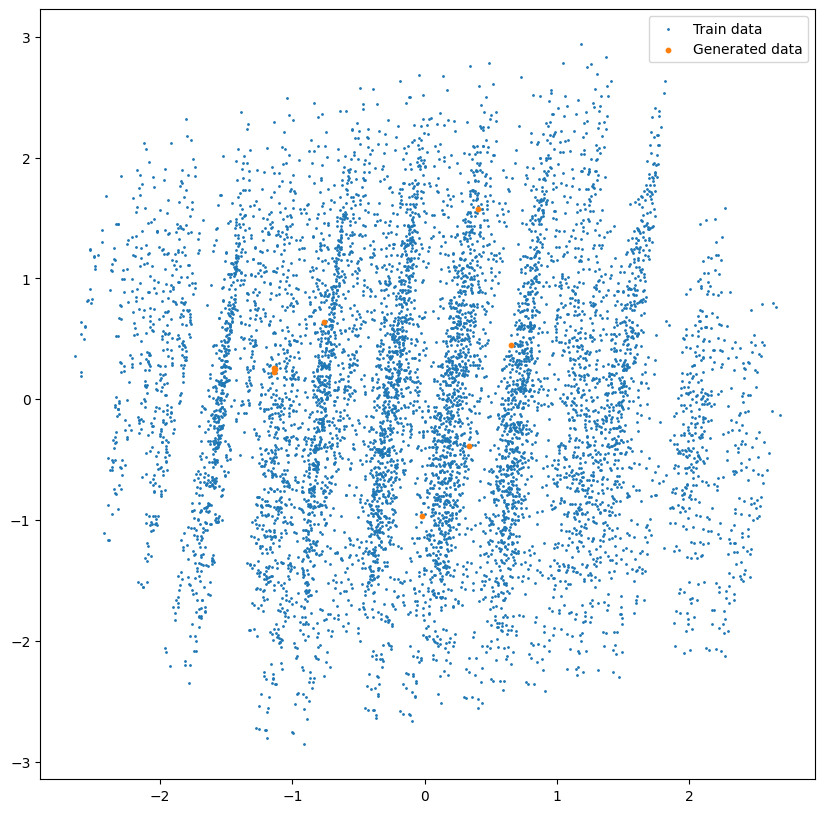

In [45]:
#Generation



vae = vae.to('cpu')
model = model.to('cpu')
sampler = DDIMSampler(model.ldm, n_steps = 8, ddim_eta  = 1)
#sampler = DDPMSampler(model.ldm)

start = torch.randn(1, 3, 8, 8).to('cpu')
#z, all_z, all_pred_z0 = sampler.sample(shape=(1, 3, 8, 8), x_last = start, cond=None,selected_time_steps = [i* 999 // 7 for i in range(8)])
z, all_z, all_pred_z0 = sampler.sample(shape=(1, 3, 8, 8), x_last = start, cond=None)
z = z.reshape(-1, 192).float()
x = vae.decoder(z).reconstruction.reshape(-1, 3, 64, 64)


all_z = all_z.squeeze(1).reshape(-1, 3*8*8)
all_pred_z0 = all_pred_z0.squeeze(1).reshape(-1, 3*8*8)

all_x = vae.decoder(all_z).reconstruction.reshape(-1, 3, 64, 64)
all_pred_x0 = vae.decoder(all_pred_z0).reconstruction.reshape(-1, 3, 64, 64)




plt.figure(figsize=(16, 24))
for i in range(8):
    plt.subplot(1, 8, i+1)
    #plt.imshow(all_x[12*i].detach().permute(1, 2, 0))
    plt.imshow(all_x[i].detach().permute(1, 2, 0))
    plt.axis('off')
plt.show()

# plt.figure(figsize=(16, 24))
# for i in range(8):
#     plt.subplot(1, 8, i+1)
#     plt.imshow(all_pred_x0[i].detach().permute(1, 2, 0))
#     plt.axis('off')
# plt.show()


train_embeddings = vae.encoder.to('cpu')(train_dataset.data).embedding
start = start.reshape(-1, 192).float()
pca = PCA(n_components=2)
train_pca = pca.fit_transform(train_embeddings.detach().numpy())

all_z_pca = pca.transform(all_z.detach().numpy())

plt.figure(figsize=(10, 10))
plt.scatter(train_pca[:, 0], train_pca[:, 1], label='Train data', s= 1)
plt.scatter(all_z_pca[:, 0], all_z_pca[:, 1], s = 10, label='Generated data')
plt.legend()
plt.show()


# plt.figure(figsize=(10, 10))
# for i in range(25):
#     plt.subplot(5, 5, i+1)
#     plt.imshow(x[i].detach().permute(1, 2, 0))
#     plt.axis('off')
# plt.show()


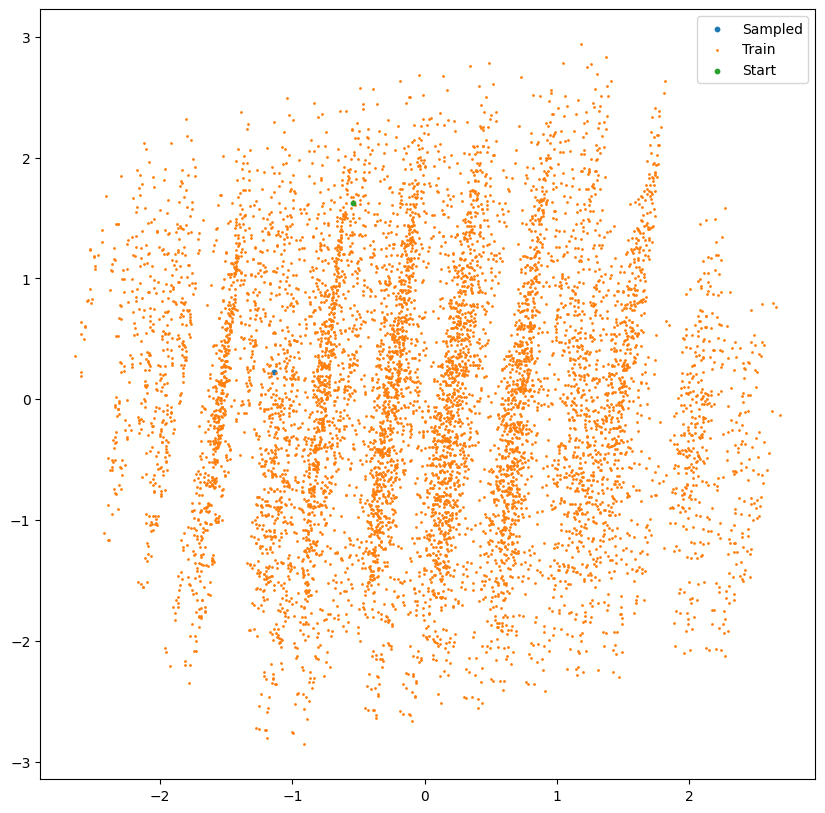

In [46]:
train_embeddings = vae.encoder.to('cpu')(train_dataset.data).embedding
start = start.reshape(-1, 192).float()
pca = PCA(n_components=2)
train_pca = pca.fit_transform(train_embeddings.detach().numpy())
z_pca = pca.transform(z.detach().numpy())
start_pca = pca.transform(start.detach().numpy())


plt.figure(figsize=(10, 10))
plt.scatter(z_pca[:, 0], z_pca[:, 1], s=10, label = "Sampled")
plt.scatter(train_pca[:, 0], train_pca[:, 1], s=1, label = "Train")
plt.scatter(start_pca[:, 0], start_pca[:, 1], s=10, label = "Start")
plt.legend()
plt.show()


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


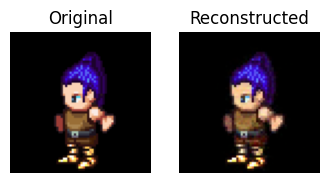

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


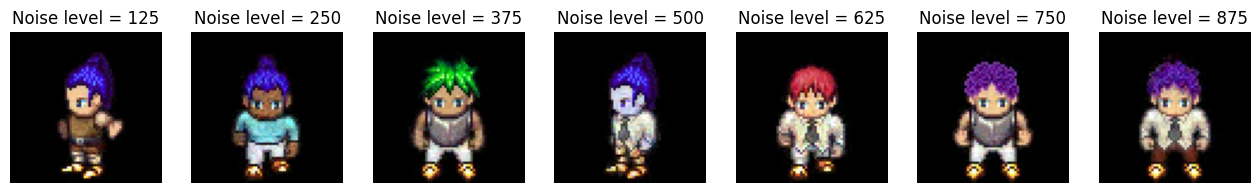

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


tensor(401.5475, grad_fn=<MseLossBackward0>)
Baseline2:  tensor(207.4251, grad_fn=<MseLossBackward0>)
Baseline3:  tensor(213.5974, grad_fn=<MseLossBackward0>)
tensor(373.1119, grad_fn=<MseLossBackward0>)
Baseline2:  tensor(206.1868, grad_fn=<MseLossBackward0>)
Baseline3:  tensor(224.3732, grad_fn=<MseLossBackward0>)
tensor(386.2857, grad_fn=<MseLossBackward0>)
Baseline2:  tensor(193.4438, grad_fn=<MseLossBackward0>)
Baseline3:  tensor(193.4022, grad_fn=<MseLossBackward0>)
tensor(273.8042, grad_fn=<MseLossBackward0>)
Baseline2:  tensor(163.9654, grad_fn=<MseLossBackward0>)
Baseline3:  tensor(139.2094, grad_fn=<MseLossBackward0>)
tensor(238.5479, grad_fn=<MseLossBackward0>)
Baseline2:  tensor(184.5951, grad_fn=<MseLossBackward0>)
Baseline3:  tensor(77.1599, grad_fn=<MseLossBackward0>)
tensor(53.7958, grad_fn=<MseLossBackward0>)
Baseline2:  tensor(40.3455, grad_fn=<MseLossBackward0>)
Baseline3:  tensor(22.1431, grad_fn=<MseLossBackward0>)
tensor(21.3251, grad_fn=<MseLossBackward0>)
Baseli

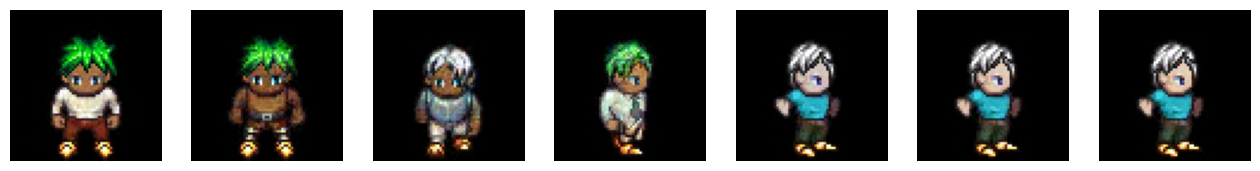

In [58]:
x = next(iter(val_loader))[1]
z_orig = vae.encoder(x).embedding.float()
x_rec = vae.decoder(z_orig).reconstruction.reshape(3, 64, 64).detach()
plt.figure(figsize=(4, 4))
plt.subplot(1, 2, 1)
plt.title('Original')
plt.imshow(x.permute(1, 2, 0))
plt.axis('off')
plt.subplot(1, 2, 2)
plt.title('Reconstructed')
plt.imshow(x_rec.permute(1, 2, 0))
plt.axis('off')
plt.show()

all_noisy_z = [z_orig]
plt.figure(figsize=(16, 24))
ts = [125*i for i in range(1, 8)]
for i in range(7):
    noise = torch.randn_like(z)
    prev_z = all_noisy_z[-1]

    #noisy_z = model.ldm.add_noise(prev_z, noise, torch.tensor([125])).float()
    #noisy_z = model.ldm.add_noise(z_orig, noise, torch.tensor([ts[i]])).float()

    if i> 0:
        noisy_z = model.ldm.sequential_diffusion(prev_z, ts[i-1], ts[i], noise).float()
    else:
        noisy_z = model.ldm.sequential_diffusion(prev_z, 0, ts[i], noise).float()

    all_noisy_z.append(noisy_z)

    noisy_x = vae.decoder(noisy_z.reshape(-1, 192)).reconstruction.reshape(3, 64, 64).detach()

    plt.subplot(1, 7, i+1)
    plt.title('Noise level = ' + str(ts[i]))
    plt.imshow(noisy_x.permute(1, 2, 0))
    plt.axis('off')
plt.show()

sampler = DDIMSampler(model.ldm, n_steps = 7, ddim_eta = 1)
sampler.time_steps = ts
#sampler = DDPMSampler(model.ldm)


start = noisy_z.reshape(-1, 3, 8, 8)
#z, all_z, all_pred_z0 = sampler.sample(shape=(1, 3, 8, 8), x_last = start, cond=None, selected_time_steps=[i* 999 // 7 +1 for i in range(8)], temperature = 0)
z, all_z, all_pred_z0 = sampler.sample(shape=(1, 3, 8, 8), x_last = start, cond=None, temperature = 1)
z = z.reshape(-1, 192).float()
x = vae.decoder(z).reconstruction.reshape(-1, 3, 64, 64)


all_z = all_z.squeeze(1).reshape(-1, 3*8*8)

all_x = vae.decoder(all_z).reconstruction.reshape(-1, 3, 64, 64).detach()
plt.figure(figsize=(16, 24))
for i in range(7):
    plt.subplot(1, 7, i+1)
    #plt.title('Pred level ' + str(ts[-i-2]) + '|' + str(ts[-i-1]))
    plt.imshow(all_x[i].permute(1, 2, 0))
    plt.axis('off')
    z_pred = all_z[i]
    z_target = all_noisy_z[-i-2].reshape(-1, 192)
    print(nn.MSELoss(reduction = 'sum')(z_pred, z_target))
    print('Baseline2: ', nn.MSELoss(reduction = 'sum')(z_orig, z_target))
    print('Baseline3: ', nn.MSELoss(reduction = 'sum')(z_pred, z_orig))
plt.show()


In [69]:
from torchmetrics.image.fid import FrechetInceptionDistance


model = model.to('cpu')
sampler = DDIMSampler(model.ldm, n_steps = 7, ddim_eta = 1)
start = torch.randn(1000, 3, 8, 8)
fake_images, _, _ = sampler.sample(shape=(1000, 3, 8, 8), x_last = start, cond=None, temperature = 1)

rand_indxes = torch.randint(0, 8000, (1000,))
real_images = vae.encoder(train_data[rand_indxes]).embedding.reshape(-1, 3, 8, 8)

fid = FrechetInceptionDistance(normalize=True)
fid.update(real_images, real=True)
fid.update(fake_images, real=False)

print(fid.compute())


tensor(11.8994)
